In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

from stog.utils.params import Params
from stog.data.dataset_builder import dataset_from_params, iterator_from_params
from stog.data.vocabulary import Vocabulary
from stog.training.trainer import Trainer
from stog.data.dataset import Batch
from model.text_to_amr import TextToAMR

from keras.layers import Embedding, Input, Dense, Flatten, LSTM, concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.losses import MeanSquaredError

[2020-02-12 22:33:08,864 INFO] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
Using TensorFlow backend.


In [3]:
params = Params.from_file("../model/model_params.yaml")

/home/adylanrff/Documents/Kuliah/TA/amr_parser/stog/utils/params.py:104: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dict_merge.dict_merge(params_dict, yaml.load(f))


In [4]:
data_params = params['data']
dataset = dataset_from_params(data_params)

[2020-02-12 22:33:10,420 INFO] Building train datasets ...
[2020-02-12 22:33:10,421 ERROR] Model name 'data/bert-base-cased/bert-base-cased-vocab.txt' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese). We assumed 'data/bert-base-cased/bert-base-cased-vocab.txt' was a path or url but couldn't find any file associated to this path or url.
0it [00:00, ?it/s][2020-02-12 22:33:10,423 INFO] Reading instances from lines in file at: ../data/raw/amr.txt.features
[2020-02-12 22:33:10,499 INFO] POS tag coverage: 0.3087 (184/596)
40it [00:00, 518.54it/s]
[2020-02-12 22:33:10,501 INFO] Building dev datasets ...
[2020-02-12 22:33:10,502 ERROR] Model name 'data/bert-base-cased/bert-base-cased-vocab.txt' was not found in model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-

In [5]:
train_data = dataset['train']
dev_data = dataset.get('dev')
test_data = dataset.get('test')

In [6]:
vocab_params = params.get('vocab', {})
vocab = Vocabulary.from_instances(instances=train_data, **vocab_params)
vocab.save_to_files("../data/processed/serialization")

dataset = Batch(train_data)
dataset.index_instances(vocab)
dataset.index_instances(vocab)

# print(dataset.as_tensor_dict()['src_tokens']['encoder_tokens'][1].numpy())
# print(dataset.as_tensor_dict()['tgt_tokens']['decoder_tokens'][1].numpy())
# print(dataset.get_padding_lengths())
# print(dataset.as_tensor_dict())

for key in dataset.as_tensor_dict():
    print(key)
    content = dataset.as_tensor_dict()[key]
    if isinstance(content, dict):
        for inner_key in content:
            print("  ", inner_key)

train_iterator, dev_iterater, test_iterater = iterator_from_params(vocab, data_params['iterator'])

train_dataset = Batch(train_data)
train_dataset.index_instances(vocab)

test_dataset = Batch(test_data)
test_dataset.index_instances(vocab)

train_dataset = train_dataset.as_tensor_dict()
test_dataset = test_dataset.as_tensor_dict()

[2020-02-12 22:33:10,674 INFO] Fitting token dictionary from dataset.
100%|██████████| 40/40 [00:00<00:00, 2356.02it/s]
[2020-02-12 22:33:10,698 WARNING] vocabulary serialization directory ../data/processed/serialization is not empty


src_tokens
   encoder_tokens
   encoder_characters
src_must_copy_tags
tgt_tokens
   decoder_tokens
   decoder_characters
src_pos_tags
tgt_pos_tags
tgt_copy_indices
tgt_copy_mask
tgt_copy_map
src_copy_indices
src_copy_map
head_tags
head_indices


In [7]:
print(vocab)

Vocabulary with namespaces:
 	Non Padded Namespaces: {'must_copy_tags', 'coref_tags'}
 	Namespace: encoder_token_ids, Size: 334 
 	Namespace: encoder_token_characters, Size: 39 
 	Namespace: decoder_token_ids, Size: 283 
 	Namespace: decoder_token_characters, Size: 65 
 	Namespace: pos_tags, Size: 16 
 	Namespace: head_tags, Size: 35 



## Test Model

In [8]:
text_to_amr = TextToAMR(vocab)
model = text_to_amr.model
model.compile(optimizer='rmsprop', loss="mean_squared_error")

[2020-02-12 22:33:11,157 WARNING] From /home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_encoder_input (InputLayer (None, 25)           0                                            
__________________________________________________________________________________________________
pos_encoder_input (InputLayer)  (None, 25)           0                                            
__________________________________________________________________________________________________
glove_embedding_1 (GloveEmbeddi (None, 25, 100)      33400       token_encoder_input[0][0]        
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 100)      1600        pos_encoder_input[0][0]          
____________________________________________________________________________________________

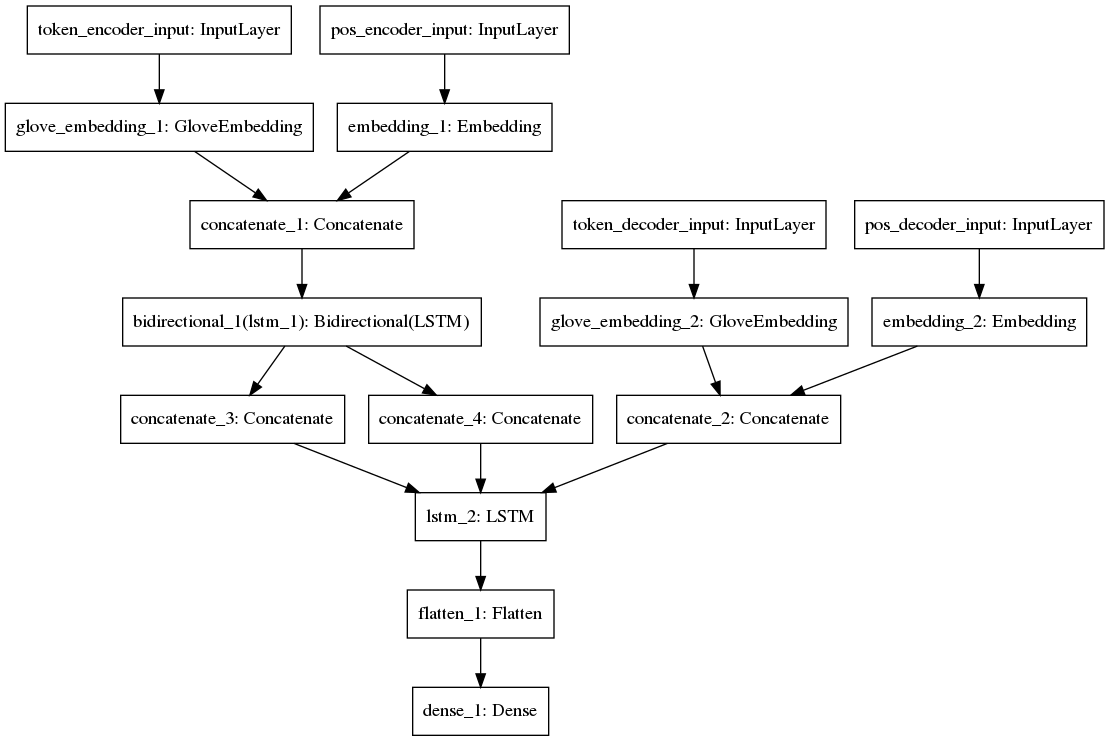

In [10]:
plot_model(model)

In [11]:
encoder_input, decoder_input = text_to_amr.prepare_input(train_dataset)

In [13]:

token_encoder_input = encoder_input.get('token').numpy()
pos_encoder_input = encoder_input.get('pos_tag').numpy()
token_decoder_input = decoder_input.get('token').numpy()
pos_decoder_input = decoder_input.get('pos_tag').numpy()

model_input = [token_encoder_input, pos_encoder_input, token_decoder_input, pos_decoder_input]
model.fit(model_input, [1 for _ in range(len(model_input[0]))], epochs=10)

Epoch 1/10
40/40 [==============================] - 0s 9ms/step - loss: 30.7261
Epoch 2/10
40/40 [==============================] - 0s 8ms/step - loss: 0.2047
Epoch 3/10
40/40 [==============================] - 0s 9ms/step - loss: 0.1282
Epoch 4/10
40/40 [==============================] - 0s 9ms/step - loss: 0.0772
Epoch 5/10
40/40 [==============================] - 0s 9ms/step - loss: 0.0459
Epoch 6/10
40/40 [==============================] - 0s 11ms/step - loss: 0.0308
Epoch 7/10
40/40 [==============================] - 0s 9ms/step - loss: 0.0254
Epoch 8/10
40/40 [==============================] - 0s 8ms/step - loss: 0.0232
Epoch 9/10
40/40 [==============================] - 0s 10ms/step - loss: 0.0211
Epoch 10/10
40/40 [==============================] - 0s 9ms/step - loss: 0.0213


array([[0.96392125],
       [0.9643069 ],
       [1.0293987 ],
       [1.0396862 ],
       [1.0576358 ],
       [1.0293806 ],
       [0.97784716],
       [0.6372025 ],
       [0.8563642 ],
       [0.99410665],
       [0.53456503],
       [0.94862187],
       [0.99534327],
       [0.9508408 ],
       [0.9255717 ],
       [0.86808795],
       [0.5114711 ],
       [1.0021183 ],
       [1.0053271 ],
       [1.0722044 ],
       [1.019841  ],
       [1.0633816 ],
       [0.80477065],
       [0.7835452 ],
       [0.95638317],
       [1.0020767 ],
       [0.90810084],
       [0.9841866 ],
       [1.0592308 ],
       [1.0352436 ],
       [1.0422039 ],
       [0.98826104],
       [1.011428  ],
       [0.99178064],
       [0.9744502 ],
       [1.030625  ],
       [0.8824213 ],
       [1.0149896 ],
       [1.0253288 ],
       [1.0010474 ]], dtype=float32)